In [1]:
%cd ../

/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet


In [2]:
from __future__ import print_function, division
import copy
import torch
import argparse
import numpy as np
import os
from torchvision import datasets, transforms
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score,\
f1_score, roc_auc_score, roc_curve, accuracy_score, matthews_corrcoef as mcc
from torch.utils.data import Subset
import pandas as pd
from scipy.spatial import distance_matrix

import argparse
import numpy as np
from scipy.cluster.vq import kmeans2
from sklearn.metrics.cluster import normalized_mutual_info_score as nmi_score
from sklearn.metrics import adjusted_rand_score as ari_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier, RandomForestClassifier
import torch.nn as nn
import torch.nn.functional as F
from torch.nn.parameter import Parameter
from torch.optim import Adam
from torch.utils.data import DataLoader, random_split
from torch.nn import Linear
from pytorchtools import EarlyStoppingEN

import numbers
from sklearn.metrics import davies_bouldin_score as dbs, adjusted_rand_score as ari
from matplotlib import pyplot as plt
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']

from models import ExpertNet,  target_distribution, source_distribution
from utils import *

In [64]:
# Dataset parameters
params = {
'dir' : 'synthetic',
'dataset' : 'cic',

# Training parameters
'lr' : 0.002,
'alpha' : 1,
'wd' : 5e-4,
'batch_size' : 512,
'n_epochs' : 100,
'n_runs' : 1,
'pre_epoch' : 40,
'pretrain' : True,
"load_ae": False,
"classifier": "LR",
"tol": 0.01,
"attention": "True",
"ablation": 'None',
"cluster_balance": 'hellinger',
"verbose": 'True',

# Model parameters
'lamda' : 1,
'beta' : 2, # KL loss/KM loss weight
'gamma' : 1.5, # Classification loss weight
'delta' : 1, # Class Balance weight
'eta' : 0.0, # Class separation weight
'hidden_dims' : [64, 32],
'n_z' : 20,
'n_clusters' : 3,
'clustering' : 'cac',
'n_classes'  : 2,

# Utility parameters
'n_jobs' : 6,
'device' : 'cpu',
'log_interval' : 2,
'other' : 'False',
'cluster_balance' : 'hellinger',
'cluster_analysis' : 'False',
'pretrain_path': '/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model'}
# 'pretrain_path': ''}


class parameters(object):
    def __init__(self, params):
        self.dir = params['dir']
        self.input_dim = -1
        self.dataset = params['dataset']
        
        # Training parameters
        self.lr = params['lr']
        self.alpha = params['alpha']
        self.wd = params['wd']
        self.batch_size = params['batch_size']
        self.n_epochs = params['n_epochs']
        self.n_runs = params['n_runs']
        self.pre_epoch = params['pre_epoch']
        self.pretrain = params['pretrain']
        self.load_ae = params['load_ae']
        self.classifier = params['classifier']
        self.tol = params['tol']
        self.attention = params['attention'] == "True"
        self.ablation = params['ablation']
        self.verbose = params['verbose']

        # Model parameters
        self.lamda = params['lamda']
        self.beta = params['beta']
        self.gamma = params['gamma']
        self.delta = params['delta']
        self.eta = params['eta']
        self.hidden_dims = params['hidden_dims']
        self.latent_dim = self.n_z = params['n_z']
        self.n_clusters = params['n_clusters']
        self.clustering = params['clustering']
        self.n_classes = params['n_classes']
        self.cluster_balance = params['cluster_balance']
        self.cluster_analysis = params['cluster_analysis']

        # Utility parameters
        self.n_jobs = params['n_jobs']
        self.device = params['device']
        self.log_interval = params['log_interval']
        self.other = params['other']
        self.pretrain_path = params['pretrain_path'] + "/" + self.dataset + ".pth"

args = parameters(params)
color = ['grey', 'red', 'blue', 'pink', 'brown', 'black', 'magenta', 'purple', 'orange', 'cyan', 'olive']
DATASETS = ['diabetes', 'ards', 'ards_new', 'cic', 'cic_new', 'sepsis', 'aki', 'aki_new', 'infant', 'wid_mortality',\
            'synthetic', 'titanic', 'magic', 'adult', 'creditcard', 'heart', 'cic_los', 'paper_synthetic']

DATA_DIR = "/Users/shivin/Document/NUS/Research/Data"
BASE_DIR = "/Users/shivin/Document/NUS/Research/cac/cac_dl/ExpertNet"


In [147]:
base_suffix = ""

for key in ['n_clusters', 'alpha', 'beta', 'gamma', 'delta', 'eta', 'attention']:
    print(key, args.__dict__[key])

base_suffix += args.dataset + "_"
base_suffix += str(args.n_clusters) + "_"
base_suffix += str(args.attention)

f1_scores, auc_scores, acc_scores = [], [], [] #Inattentive test results
e_f1_scores, e_auc_scores, e_acc_scores = [], [], [] #Attentive test results
sil_scores, wdfd_scores, HTFD_scores, w_HTFD_scores = [], [], [], []

# to track the training loss as the model trains
test_losses, e_test_losses, local_sum_test_losses = [], [], []
model_complexity = []


if args.ablation == "alpha":
    iter_array = alphas
    iteration_name = "Alpha"

elif args.ablation == "beta":
    iter_array = betas
    iteration_name = "Beta"

elif args.ablation == "gamma":
    iter_array = gammas
    iteration_name = "Gamma"

elif args.ablation == "delta":
    iter_array = deltas
    iteration_name = "Delta"

elif args.ablation == "k":
    iter_array = ks
    iteration_name = "K"

else:
    iter_array = range(args.n_runs)
    iteration_name = "Run"

n_clusters 3
alpha 1
beta 2
gamma 1.5
delta 1
eta 0.0
attention True


Index(['SAPS-I', 'SOFA', 'Length_of_stay', 'Age', 'Height', 'Weight', 'CCU',
       'CSRU', 'SICU', 'DiasABP_first',
       ...
       'SysABP_last', 'TroponinI_last', 'TroponinT_last', 'WBC_last',
       'Weight_last', 'pH_last', 'MechVentStartTime', 'MechVentDuration',
       'MechVentLast8Hour', 'UrineOutputSum'],
      dtype='object', length=116)

In [148]:
scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=0)
X_train_orig, y_train_orig = train_data
X_val_orig, y_val_orig = val_data
X_test_orig, y_test_orig = test_data

In [155]:
def extract_column(X, y, col_idx, n_classes):
    if col_idx == -1:
        return X, y
    los_quantiles = np.quantile(X[:,col_idx], np.arange(n_classes+1)/n_classes)
    y_new = []
    for i in range(len(X)):
        lbl = int(X[i,col_idx]/n_classes)
        for j in range(n_classes):
            if los_quantiles[j] <= X[i,col_idx] <= los_quantiles[j+1]:
                lbl = j
        y_new.append(lbl)

    X_new = np.delete(X, col_idx, 1) # delete col_idx column
    y_new = np.array(y_new)
    args.input_dim -= 1
    return X_new, y_new

In [157]:
####################################################################################
####################################################################################
####################################################################################
################################### Initialiation ##################################
####################################################################################
####################################################################################
####################################################################################
def run_ExpertNet(args, iter_array, y_col, k):
    for r in range(len(iter_array)):
        scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=r)
        X_train, y_train = train_data
        X_val, y_val = val_data
        X_test, y_test = test_data

        X_train, y_train = extract_column(X_train, y_train, y_col, k)
        X_val, y_val = extract_column(X_val, y_val, y_col, k)
        X_test, y_test = extract_column(X_test, y_test, y_col, k)
        column_names = column_names.delete(y_col)

        train_loader = generate_data_loaders(X_train, y_train, args.batch_size)
        val_loader = generate_data_loaders(X_val, y_val, args.batch_size)
        test_loader = generate_data_loaders(X_test, y_test, args.batch_size)

        print(sum(y_train), len(y_train))
        print(sum(y_val), len(y_val))
        print(sum(y_test), len(y_test))

        if args.verbose == 'False':
            blockPrint()

        print(iteration_name, ":", iter_array[r])

        if args.ablation == "beta":
            args.beta = iter_array[r]

        elif args.ablation == "gamma":
            args.gamma = iter_array[r]

        elif args.ablation == "delta":
            args.delta = iter_array[r]

        elif args.ablation == "k":
            args.n_clusters = iter_array[r]

        suffix = base_suffix + "_" + iteration_name + "_" + str(iter_array[r])
        ae_layers = [128, 64, 32, args.n_z, 32, 64, 128]
        expert_layers = [args.n_z, 64, 32, 16, args.n_classes]
        # ae_layers = [64, 32, 64]

        model = ExpertNet(
                ae_layers,
                expert_layers,
                args=args).to(args.device)

        model.pretrain(train_loader, args.pretrain_path)

        optimizer = Adam(model.parameters(), lr=args.lr)

        # Initiate cluster parameters
        device = args.device
        y = y_train
        x_bar, hidden = model.ae(torch.Tensor(X_train).to(args.device))
        original_cluster_centers, original_cluster_indices = kmeans2(hidden.data.cpu().numpy(), k=args.n_clusters, minit='++')
        model.cluster_layer.data = torch.tensor(original_cluster_centers).to(device)
        criterion = nn.CrossEntropyLoss(reduction='none')

        # plot_data(torch.Tensor(X_train).to(args.device), y_train, cluster_indices)

        for i in range(args.n_clusters):
            cluster_idx = np.where(original_cluster_indices == i)[0]
            cluster_idx_p = np.where(y[cluster_idx] == 1)[0]
            cluster_idx_n = np.where(y[cluster_idx] == 0)[0]
            hidden_p = hidden[cluster_idx][cluster_idx_p]
            hidden_n = hidden[cluster_idx][cluster_idx_n]

            model.p_cluster_layer.data[i,:] = torch.mean(hidden_p, axis=0)
            model.n_cluster_layer.data[i,:] = torch.mean(hidden_n, axis=0)

        ####################################################################################
        ####################################################################################
        ####################################################################################
        ################################## Clustering Step #################################
        ####################################################################################
        ####################################################################################
        ####################################################################################


        print("Starting Training")
        model.train()
        N_EPOCHS = args.n_epochs
        es = EarlyStoppingEN(dataset=suffix)
        train_losses, e_train_losses = [], []

        for epoch in range(N_EPOCHS):
            beta = args.beta
            gamma = args.gamma
            delta = args.delta
            eta = args.eta
            if epoch % args.log_interval == 0:
                # plot(model, torch.FloatTensor(X_val).to(args.device), y_val, labels=None)
                model.ae.eval() # prep model for evaluation
                for j in range(model.n_clusters):
                    model.classifiers[j][0].eval()

                z_train, _, q_train = model(torch.Tensor(X_train).to(args.device), output="decoded")
                q_train, q_train_p, q_train_n = q_train
                p_train = target_distribution(q_train.detach())

                # evaluate clustering performance
                cluster_indices = q_train.detach().cpu().numpy().argmax(1)
                preds = torch.zeros((len(z_train), args.n_classes))

                # Calculate Training Metrics
                nmi, acc, ari = 0, 0, 0
                train_loss = 0
                B = []

                for j in range(model.n_clusters):
                    cluster_idx = np.where(cluster_indices == j)[0]
                    X_cluster = z_train[cluster_idx]
                    y_cluster = torch.Tensor(y_train[cluster_idx]).type(torch.LongTensor).to(model.device)

                    # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)
                    cluster_preds = model.classifiers[j][0](X_cluster)
                    train_loss += torch.sum(criterion(cluster_preds, y_cluster))

                train_loss /= len(z_train)

                # Evaluate model on Validation dataset
                qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
                q_val = qs[0]
                cluster_ids = torch.argmax(q_val, axis=1)
                preds = torch.zeros((len(z_val), args.n_classes))

                # Weighted predictions
                if args.attention == False:
                    for j in range(model.n_clusters):
                        cluster_id = np.where(cluster_ids == j)[0]
                        X_cluster = z_val[cluster_id]
                        cluster_preds_val = model.classifiers[j][0](X_cluster)
                        preds[cluster_id,:] = cluster_preds_val

                else:
                    for j in range(model.n_clusters):
                        X_cluster = z_val
                        cluster_preds = model.classifiers[j][0](X_cluster)
                        for c in range(args.n_classes):
                            preds[:,c] += q_val[:,j]*cluster_preds[:,c]

                # Classification Matrics
                val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
                val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)

                # Clustering Metrics
                val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids.data.cpu().numpy(), metric='euclidean')
                val_feature_diff, val_WDFD = 0, 0
                val_feature_diff = calculate_HTFD(X_val, cluster_ids)
                val_WDFD = calculate_WDFD(X_val, cluster_ids)
                val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))

                epoch_len = len(str(N_EPOCHS))

                print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                             f'train_loss: {train_loss:.3f} ' +
                             f'valid_loss: {val_loss:.3f} '  +
                             f'valid_F1: {val_f1:.3f} '  +
                             f'valid_AUC: {val_auc:.3f} ' + 
                             f'valid_Feature_p: {val_feature_diff:.3f} ' + 
                             f'valid_WDFD: {val_WDFD:.3f} ' + 
                             f'valid_Silhouette: {val_sil:.3f}')

                print(print_msg)

                # early_stopping needs the validation loss to check if it has decresed, 
                # and if it has, it will make a checkpoint of the current model
                es([val_f1, val_auc], model)
                if es.early_stop == True:
                    break

            # Normal Training
            epoch_loss = 0
            epoch_balance_loss = 0
            epoch_class_loss = 0
            epoch_km_loss = 0

            model.ae.train() # prep model for evaluation
            for j in range(model.n_clusters):
                model.classifiers[j][0].train()

            for batch_idx, (x_batch, y_batch, idx) in enumerate(train_loader):
                total_loss = 0
                x_batch = x_batch.to(device)
                idx = idx.to(device)

                X_latents, x_bar, q_batch = model(x_batch)
                q_batch = q_batch[0]
                reconstr_loss = F.mse_loss(x_bar, x_batch)

                classifier_labels = np.zeros(len(idx))
                if args.eta > 0:
                    sub_epochs = 0
                else:
                    sub_epochs = min(10, 1 + int(epoch/5))

                if args.attention == False:
                    classifier_labels = np.argmax(q_batch.detach().cpu().numpy(), axis=1)

                for _ in range(sub_epochs):
                    # Choose classifier for a point probabilistically
                    if args.attention == True:
                        for j in range(len(idx)):
                            classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())

                    for k in range(args.n_clusters):
                        idx_cluster = np.where(classifier_labels == k)[0]
                        X_cluster = X_latents[idx_cluster]
                        y_cluster = y_batch[idx_cluster]

                        classifier_k, optimizer_k = model.classifiers[k]
                        # Do not backprop the error to encoder
                        y_pred_cluster = classifier_k(X_cluster.detach())
                        cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                        optimizer_k.zero_grad()
                        cluster_loss.backward(retain_graph=True)
                        optimizer_k.step()

                # Back propagate the error corresponding to last clustering
                class_loss = torch.tensor(0.).to(args.device)
                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]
                    y_pred_cluster = classifier_k(X_cluster)
                    class_loss += torch.sum(q_batch[idx_cluster,k]*criterion(y_pred_cluster, y_cluster))

                class_loss /= len(X_latents)
                cluster_id = torch.argmax(q_batch, 1)
                delta_mu   = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
                delta_mu_p = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)
                delta_mu_n = torch.zeros((args.n_clusters, args.latent_dim)).to(args.device)

                positive_class_dist = 0
                negative_class_dist = 0
                km_loss             = 0
                dcn_loss            = 0
                class_sep_loss      = 0

                if args.eta > 0:
                    for j in range(args.n_clusters):
                        pts_index = np.where(cluster_id == j)[0]
                        cluster_pts = X_latents[pts_index]
                        n_class_index = np.where(y_batch[pts_index] == 0)[0]
                        p_class_index = np.where(y_batch[pts_index] == 1)[0]
                        n_class = X_latents[n_class_index]
                        p_class = X_latents[p_class_index]
                        delta_mu_p[j,:] = p_class.sum(axis=0)/(1+len(p_class))
                        delta_mu_n[j,:] = n_class.sum(axis=0)/(1+len(n_class))
                        delta_mu[j,:]   = cluster_pts.sum(axis=0)/(1+len(cluster_pts))
                        s1 = torch.linalg.norm(cluster_pts[p_class_index] - model.p_cluster_layer[j])/(1+len(p_class))
                        s2 = torch.linalg.norm(cluster_pts[n_class_index] - model.n_cluster_layer[j])/(1+len(n_class))
                        m12 = torch.linalg.norm(model.p_cluster_layer[j] - model.n_cluster_layer[j])
                        class_sep_loss = -(s1 + s1)/m12
                        dcn_loss += torch.linalg.norm(X_latents[pts_index] - model.cluster_layer[j])/(1+len(cluster_pts))
                        dcn_loss -= args.eta*class_sep_loss

                q_batch = source_distribution(X_latents, model.cluster_layer, alpha=model.alpha)
                P = torch.sum(torch.nn.Softmax(dim=1)(10*q_batch), axis=0)
                P = P/P.sum()
                Q = torch.ones(args.n_clusters)/args.n_clusters # Uniform distribution

                if args.cluster_balance == "kl":
                    cluster_balance_loss = F.kl_div(P.log(), Q, reduction='batchmean')
                else:
                    cluster_balance_loss = torch.linalg.norm(torch.sqrt(P) - torch.sqrt(Q))

                km_loss = F.kl_div(q_batch.log(), p_train[idx], reduction='batchmean')

                loss = reconstr_loss
                if args.beta != 0:
                    loss += beta*km_loss
                if args.gamma != 0:
                    loss += gamma*class_loss
                if args.delta != 0:
                    loss += delta*cluster_balance_loss
                if args.eta != 0:
                    loss += dcn_loss

                epoch_loss += loss
                epoch_class_loss += class_loss
                epoch_balance_loss += cluster_balance_loss
                epoch_km_loss += km_loss
                optimizer.zero_grad()
                loss.backward(retain_graph=True)
                optimizer.step()

                # Update the positive and negative centroids
                if args.eta > 0:
                    for j in range(args.n_clusters):
                        pts_index = np.where(cluster_id == j)[0]
                        n_class_index = np.where(y[pts_index] == 0)[0]
                        p_class_index = np.where(y[pts_index] == 1)[0]
                        N  = len(pts_index)
                        Np = len(p_class_index)
                        Nn = len(n_class_index)
                        model.p_cluster_layer.data[j:] -= (1/(100+Np))*delta_mu_p[j:]
                        model.n_cluster_layer.data[j:] -= (1/(100+Nn))*delta_mu_n[j:]
                        model.cluster_layer.data[j:]   -= (1/(100+N))*delta_mu[j:]

            print('Epoch: {:02d} | Epoch KM Loss: {:.3f} | Total Loss: {:.3f} | Classification Loss: {:.3f} |\
            Cluster Balance Loss: {:.3f}'.format(epoch, epoch_km_loss, epoch_loss, epoch_class_loss, loss))
            train_losses.append([np.round(epoch_loss.item(),3), np.round(epoch_class_loss.item(),3)])

        ####################################################################################
        ####################################################################################
        ####################################################################################
        ################################### Local Training #################################
        ####################################################################################
        ####################################################################################
        ####################################################################################
        print("\n####################################################################################\n")
        print("Training Local Networks")
        model = es.load_checkpoint(model)

        es = EarlyStoppingEN(dataset=suffix)

        qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
        q_train = qs[0]
        cluster_id_train = torch.argmax(q_train, axis=1)

        X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

        train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
            batch_size=1024, shuffle=False)

        B = []

        print(np.bincount(cluster_id_train))
        # plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
             # torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

        # Post clustering training
        for e in range(N_EPOCHS):
            epoch_loss = 0
            epoch_acc = 0
            epoch_f1 = 0
            acc = 0

            for j in range(model.n_clusters):
                model.classifiers[j][0].train()

            # Full training of local networks
            for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
                classifier_labels = np.zeros(len(X_latents))

                # Choose classifier for a point probabilistically
                if args.attention == True:
                    for j in range(len(X_latents)):
                        classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
                else:
                    classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

                for k in range(args.n_clusters):
                    idx_cluster = np.where(classifier_labels == k)[0]
                    X_cluster = X_latents[idx_cluster]
                    y_cluster = y_batch[idx_cluster]

                    classifier_k, optimizer_k = model.classifiers[k]

                    # Do not backprop the error to encoder
                    y_pred_cluster = classifier_k(X_cluster.detach())
                    cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
                    optimizer_k.zero_grad()
                    cluster_loss.backward(retain_graph=True)
                    optimizer_k.step()

            for j in range(model.n_clusters):
                model.classifiers[j][0].eval()

            train_preds = torch.zeros((len(z_train), args.n_classes))
            train_loss = 0

            # Weighted predictions
            q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
            q_train = q_train[0]
            cluster_ids_train = torch.argmax(q_train, axis=1)

            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids_train == j)[0]
                X_cluster = z_train
                y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

                # Ensemble train loss
                cluster_preds = model.classifiers[j][0](X_cluster)
                for c in range(args.n_classes):
                    train_preds[:,c] += q_train[:,j]*cluster_preds[:,c]

                X_cluster = z_train[cluster_id]
                cluster_preds = model.classifiers[j][0](X_cluster)
                train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
                # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


            train_loss /= len(z_train)
            e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

            # Evaluate model on Validation set
            qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
            q_val = qs[0]
            cluster_ids_val = torch.argmax(q_val, axis=1)
            preds = torch.zeros((len(z_val), args.n_classes))

            # Weighted predictions
            for j in range(model.n_clusters):
                cluster_id = np.where(cluster_ids_val == j)[0]
                X_cluster = z_val
                cluster_preds = model.classifiers[j][0](X_cluster)
                for c in range(args.n_classes):
                    preds[:,c] += q_val[:,j]*cluster_preds[:,c]

            val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1), average="macro")
            val_auc = multi_class_auc(y_val, preds.detach().numpy(), args.n_classes)
            val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')
            val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
            epoch_len = len(str(N_EPOCHS))

            print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                         f'train_loss: {train_loss:.3f} ' +
                         f'valid_loss: {val_loss:.3f} '  +
                         f'valid_F1: {val_f1:.3f} '  +
                         f'valid_AUC: {val_auc:.3f} ' +
                         f'valid_Sil: {val_sil:.3f}')

            print(print_msg)

            # early_stopping needs the validation loss to check if it has decresed, 
            # and if it has, it will make a checkpoint of the current model
            es([val_f1, val_auc], model)
            if es.early_stop == True:
                # train_losses.append(train_loss.item())
                sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
                HTFD_scores.append(calculate_HTFD(X_train, cluster_ids_train))
                wdfd_scores.append(calculate_WDFD(X_train, cluster_ids_train))
                break


        ####################################################################################
        ####################################################################################
        ####################################################################################
        ################################### Testing Perf. ##################################
        ####################################################################################
        ####################################################################################
        ####################################################################################

        print("\n####################################################################################\n")
        print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

        # Load best model trained from local training phase
        model = es.load_checkpoint(model)

        # # Evaluate model on Test dataset
        qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
        q_test = qs[0]
        cluster_ids = torch.argmax(q_test, axis=1)
        test_preds_e = torch.zeros((len(z_test), args.n_classes))

        test_loss = 0
        e_test_loss = 0
        local_sum_loss = 0

        # Weighted predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            X_cluster = z_test
            cluster_test_preds = model.classifiers[j][0](X_cluster)
            for c in range(args.n_classes):
                test_preds_e[:,c] += q_test[:,j]*cluster_test_preds[:,c]

        e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
        e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1), average="macro")
        e_test_auc = multi_class_auc(y_test, test_preds_e.detach().numpy(), args.n_classes)
        e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
        e_test_HTFD = calculate_HTFD(X_test, cluster_ids)

        test_preds = torch.zeros((len(z_test), args.n_classes))

        # Hard local predictions
        for j in range(model.n_clusters):
            cluster_id = np.where(cluster_ids == j)[0]
            X_cluster = z_test[cluster_id]
            y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
            cluster_test_preds = model.classifiers[j][0](X_cluster)
            test_preds[cluster_id,:] = cluster_test_preds
            local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

        test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1), average="macro")
        test_auc = multi_class_auc(y_test, test_preds.detach().numpy(), args.n_classes)
        test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
        test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
        local_sum_loss /= len(X_test)

        test_losses.append(test_loss.item())
        e_test_losses.append(e_test_loss.item())
        local_sum_test_losses.append(local_sum_loss.item())

        print("Run #{}".format(r))
        print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

        print('Clustering Metrics - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
              ', ari {:.4f}, HTFD {:.3f}'.format(ari, e_test_HTFD))

        print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
            ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

        print("\n")

        f1_scores.append(test_f1)
        auc_scores.append(test_auc)
        acc_scores.append(test_acc)

        e_f1_scores.append(e_test_f1)
        e_auc_scores.append(e_test_auc)
        e_acc_scores.append(e_test_acc)
    return model, (X_train, y_train), (X_val, y_val), (X_test, y_test), column_names

In [ ]:
dd

In [16]:
scale, column_names, train_data, val_data, test_data = get_train_val_test_loaders(args, r_state=r)

In [23]:
print(y_new)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [169]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

def train_student_model(args, X_train, y_train, X_test, y_test, column_names):
    regs = [GradientBoostingClassifier(random_state=0) for _ in range(args.n_clusters)]
    qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = qs[0]
    cluster_ids = torch.argmax(q_train, axis=1)
    train_preds = torch.zeros((len(z_train), args.n_classes))
    feature_importances = np.zeros((args.n_clusters, args.input_dim))

    # Weighted predictions... should be wihout attention only
    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids == j)[0]
        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        # print(q_test, cluster_preds[:,0])
        train_preds[cluster_id,:] = cluster_preds
        # y_cluster = np.argmax(train_preds[cluster_id].detach().numpy(), axis=1)
        y_cluster = y_train[cluster_id]

        # Train the local regressors on the data embeddings
        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            regs[j].fit(X_train[cluster_id], y_cluster)
            best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
            feature_importances[j,:] = regs[j].feature_importances_
            print("Cluster # ", j, "sized: ", len(cluster_id), "label distr: ", sum(y_cluster)/len(y_cluster))
            print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
#             for f in best_features:
#                 print(X_train[cluster_id][:,f])

            print("=========================\n")

    # Testing performance of downstream classifier on cluster embeddings
    qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
    q_test = qs[0]
    cluster_ids_test = torch.argmax(q_test, axis=1)
    test_preds = torch.zeros((len(z_test), args.n_classes))
    y_pred = np.zeros((len(z_test), args.n_classes))

    for j in range(model.n_clusters):
        cluster_id = torch.where(cluster_ids_test == j)[0]
        X_cluster = X_test[cluster_id]
    #     cluster_preds = model.classifiers[j][0](X_cluster)
    #     test_preds[cluster_id,:] = cluster_preds
    #     y_cluster = test_preds[cluster_id]

        # Some test data might not belong to any cluster
        if len(cluster_id) > 0:
            y_pred[cluster_id] = regs[j].predict_proba(X_cluster)

    feature_diff = 0
    cntr = 0
    for i in range(args.n_clusters):
        for j in range(args.n_clusters):
            if i > j:
                ci = torch.where(cluster_ids == i)[0]
                cj = torch.where(cluster_ids == j)[0]
                Xi = X_train[ci]
                Xj = X_train[cj]
                feature_diff += 100*sum(feature_importances[i]*feature_importances[j]*(ttest_ind(Xi, Xj, axis=0)[1] < 0.05))/args.input_dim
                # print("Cluster [{}, {}] p-value: ".format(i,j), feature_diff)
                cntr += 1

    if cntr == 0:
        w_HTFD_scores.append(0)
    else:
        print("Average Feature Difference: ", feature_diff/cntr)
        w_HTFD_scores.append(feature_diff/cntr)
    
    return y_pred, cluster_ids, regs

## Use ExpertNet to cluster using gender variable

In [123]:
# trained model and modified training data and labels
y_col, k = 4, 2
model, train, val, test, column_names = run_ExpertNet(args, iter_array, y_col, k)
X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

3770 6750
1260 2250
1697 3000
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic.pth
load pretrained ae from /Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic.pth
Starting Training

Cluster Wise discriminative features (HTFD)

[  0/100] train_loss: 0.690 valid_loss: 0.689 valid_F1: 0.446 valid_AUC: 0.514 valid_Feature_p: 0.747 valid_WDFD: 0.795 valid_Silhouette: 0.286
Epoch: 00 | Epoch KM Loss: 1.025 | Total Loss: 21.605 | Classification Loss: 5.356 |            Cluster Balance Loss: 1.466
Epoch: 01 | Epoch KM Loss: 0.878 | Total Loss: 19.980 | Classification Loss: 5.248 |            Cluster Balance Loss: 1.338

Cluster Wise discriminative features (HTFD)

[  2/100] train_loss: 0.635 valid_loss: 0.641 valid_F1: 0.600 valid_AUC: 0.671 valid_Feature_p: 0.720 valid_WDFD: 0.593 valid_Silhouette: 0.295
Epoch: 02 | Epoch KM Loss: 1.256 | Total Loss: 19.847 | Classification Loss: 5.164 |            Cluster Balance Loss: 1.491
Epoc


[ 32/100] train_loss: 0.302 valid_loss: 0.598 valid_F1: 0.704 valid_AUC: 0.776 valid_Sil: 0.366

[ 32/100] train_loss: 0.303 valid_loss: 0.604 valid_F1: 0.707 valid_AUC: 0.774 valid_Sil: 0.366
EarlyStopping counter: 1 out of 7

[ 32/100] train_loss: 0.299 valid_loss: 0.597 valid_F1: 0.702 valid_AUC: 0.776 valid_Sil: 0.366

[ 32/100] train_loss: 0.300 valid_loss: 0.601 valid_F1: 0.707 valid_AUC: 0.776 valid_Sil: 0.366

[ 32/100] train_loss: 0.299 valid_loss: 0.599 valid_F1: 0.708 valid_AUC: 0.776 valid_Sil: 0.366

[ 32/100] train_loss: 0.297 valid_loss: 0.600 valid_F1: 0.712 valid_AUC: 0.777 valid_Sil: 0.366

[ 32/100] train_loss: 0.300 valid_loss: 0.601 valid_F1: 0.710 valid_AUC: 0.777 valid_Sil: 0.366

[ 32/100] train_loss: 0.296 valid_loss: 0.598 valid_F1: 0.708 valid_AUC: 0.776 valid_Sil: 0.366
EarlyStopping counter: 1 out of 7

[ 32/100] train_loss: 0.298 valid_loss: 0.602 valid_F1: 0.711 valid_AUC: 0.775 valid_Sil: 0.366
EarlyStopping counter: 2 out of 7

[ 32/100] train_loss: 0.

In [116]:
X_train.shape

(6750, 116)

In [125]:
args.input_dim += 1

In [129]:
y_pred, cluster_ids_gender, regs = train_student_model(args, X_train, y_train, X_test, y_test, column_names)

Cluster #  0 sized:  2354 label distr:  0.5531011045029737
[('Height', 0.433), ('Creatinine_last', 0.098), ('Weight', 0.069), ('NIDiasABP_median', 0.034), ('Creatinine_first', 0.027), ('pH_last', 0.024), ('NIDiasABP_lowest', 0.016), ('Weight_first', 0.015), ('Platelets_last', 0.012), ('Platelets_first', 0.012)]

Cluster #  1 sized:  2138 label distr:  0.5729653882132835
[('Height', 0.47), ('Creatinine_last', 0.055), ('Weight', 0.054), ('Platelets_last', 0.029), ('HCT_first', 0.023), ('BUN_last', 0.014), ('HCT_last', 0.013), ('Creatinine_first', 0.013), ('NIDiasABP_first', 0.012), ('Platelets_first', 0.012)]

Cluster #  2 sized:  2258 label distr:  0.5504871567759079
[('Height', 0.399), ('Weight', 0.095), ('Creatinine_last', 0.084), ('Creatinine_first', 0.031), ('NIDiasABP_median', 0.028), ('Platelets_last', 0.025), ('HCT_first', 0.016), ('Weight_first', 0.016), ('HCT_last', 0.014), ('pH_last', 0.013)]

Average Feature Difference:  0.012286326920416006


### Clusters with gender variable and predicting mortality variable... should give bad AUC

In [130]:
print("AUC =", multi_class_auc(y_test_orig, y_pred, args.n_classes))
print(calculate_HTFD(X_train, cluster_ids))
print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

AUC = 0.5017605122018576

Cluster Wise discriminative features (HTFD)
1.0169942528735643
NMI with original k-means clusters 0.46302939626949163


In [110]:
print(args.input_dim)

117


### Clusters with gender variable and predicting gender variable... gives good AUC

In [131]:
print("AUC =", multi_class_auc(y_test, y_pred, args.n_classes))
print(calculate_HTFD(X_train, cluster_ids))
print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

AUC = 0.7742687085828407

Cluster Wise discriminative features (HTFD)
1.0169942528735643
NMI with original k-means clusters 0.46302939626949163


In [52]:
cluster_ids_los = cluster_ids

#### [TODO]: take raw features, just train using raw features w./o clustering. Secondly append cluster labels as another feature.

In [22]:
cluster_ids_mortality = cluster_ids

## Use ExpertNet to cluster using normal mortality variable

In [176]:
# trained model and modified training data and labels
y_col, k = -1, 2
model, train, val, test, column_names = run_ExpertNet(args, iter_array, y_col, k)
X_train, y_train = train
X_val, y_val = val
X_test, y_test = test

954 6750
325 2250
428 3000
Run : 0
/Users/shivin/Document/NUS/Research/CAC/CAC_DL/ExpertNet/pretrained_model/cic.pth


RuntimeError: Error(s) in loading state_dict for AE:
	Missing key(s) in state_dict: "encoder.layer2.weight", "encoder.layer2.bias", "decoder.layer5.weight", "decoder.layer5.bias", "decoder.layer6.weight", "decoder.layer6.bias". 
	Unexpected key(s) in state_dict: "decoder.layer3.weight", "decoder.layer3.bias". 
	size mismatch for encoder.layer0.weight: copying a param with shape torch.Size([64, 117]) from checkpoint, the shape in current model is torch.Size([128, 117]).
	size mismatch for encoder.layer0.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([128]).
	size mismatch for encoder.layer1.weight: copying a param with shape torch.Size([32, 64]) from checkpoint, the shape in current model is torch.Size([64, 128]).
	size mismatch for encoder.layer1.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([64]).
	size mismatch for decoder.layer4.weight: copying a param with shape torch.Size([64, 32]) from checkpoint, the shape in current model is torch.Size([32, 20]).
	size mismatch for decoder.layer4.bias: copying a param with shape torch.Size([64]) from checkpoint, the shape in current model is torch.Size([32]).
	size mismatch for x_bar_layer.weight: copying a param with shape torch.Size([117, 64]) from checkpoint, the shape in current model is torch.Size([117, 128]).

In [129]:
y_pred, cluster_ids_gender, regs = train_student_model(args, X_train, y_train, X_test, y_test, column_names)

Cluster #  0 sized:  2354 label distr:  0.5531011045029737
[('Height', 0.433), ('Creatinine_last', 0.098), ('Weight', 0.069), ('NIDiasABP_median', 0.034), ('Creatinine_first', 0.027), ('pH_last', 0.024), ('NIDiasABP_lowest', 0.016), ('Weight_first', 0.015), ('Platelets_last', 0.012), ('Platelets_first', 0.012)]

Cluster #  1 sized:  2138 label distr:  0.5729653882132835
[('Height', 0.47), ('Creatinine_last', 0.055), ('Weight', 0.054), ('Platelets_last', 0.029), ('HCT_first', 0.023), ('BUN_last', 0.014), ('HCT_last', 0.013), ('Creatinine_first', 0.013), ('NIDiasABP_first', 0.012), ('Platelets_first', 0.012)]

Cluster #  2 sized:  2258 label distr:  0.5504871567759079
[('Height', 0.399), ('Weight', 0.095), ('Creatinine_last', 0.084), ('Creatinine_first', 0.031), ('NIDiasABP_median', 0.028), ('Platelets_last', 0.025), ('HCT_first', 0.016), ('Weight_first', 0.016), ('HCT_last', 0.014), ('pH_last', 0.013)]

Average Feature Difference:  0.012286326920416006


In [163]:
_, y_test_gender = extract_column(X_test, y_test, 4, 2)

### Clusters with mortality variable and predicting gender variable... should give bad AUC


In [164]:
print("AUC =", multi_class_auc(y_test_gender, y_pred, args.n_classes))
print(calculate_HTFD(X_train, cluster_ids))
print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

AUC = 0.44134224497114904

Cluster Wise discriminative features (HTFD)
1.009039886039887
NMI with original k-means clusters 0.46302939626949163


### Clusters with mortality variable and predicting mortality variable... gives good AUC

In [165]:
print("AUC =", multi_class_auc(y_test, y_pred, args.n_classes))
print(calculate_HTFD(X_train, cluster_ids))
print("NMI with original k-means clusters", nmi_score(cluster_ids, original_cluster_indices))

AUC = 0.846165026671124

Cluster Wise discriminative features (HTFD)
1.009039886039887
NMI with original k-means clusters 0.46302939626949163


## MIFD Cluster Analysis

Mutual Information based feature discrimination

In [6]:
def plot_hist(x, y, bins=10):
    minn = min(np.min(x), np.min(y))
    maxx = max(np.max(x), np.max(y))
    range_x = np.max(x) - np.min(x)
    range_y = np.max(y) - np.min(y)
    gap = min(range_x, range_y)/bins

    if gap < 1e-5:
        return 0

    h1, r1 = np.histogram(x, np.arange(minn-gap, maxx+gap, gap))
    h2, r2 = np.histogram(y, np.arange(minn-gap, maxx+gap, gap))
    k1 = [(r1[j]+r1[j-1])/2 for j in range(1, len(r1))]
    k2 = [(r2[j]+r2[j-1])/2 for j in range(1, len(r2))]
    # print(h1, h2, k1)

    fig, axes = plt.subplots(1, 2)

    axes[0].bar(k1, h1, label='X1', alpha=.5)
    axes[1].bar(k2, h2, label='X2', alpha=.5)
    # axes[0].hist(h1, bins=r1, label='X1', alpha=.5)
    # axes[1].hist(h2, bins=r2, label='X2', alpha=.5)
    plt.show()



MIFD Analysis of Clusters:  1,0
|C1| =  2426 , |C2| =  2086
MI = 0.728 ; Feature: SICU - C1 Mean: -0.095 , C2 Mean: 0.012


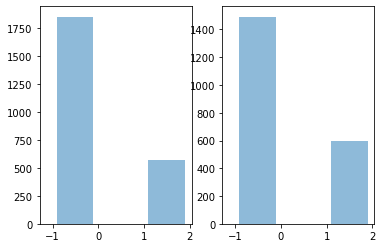

MI = 0.568 ; Feature: CCU - C1 Mean: 0.185 , C2 Mean: -0.194


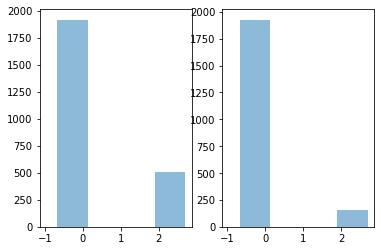

MI = 0.517 ; Feature: HCT_last - C1 Mean: 0.11 , C2 Mean: -0.135


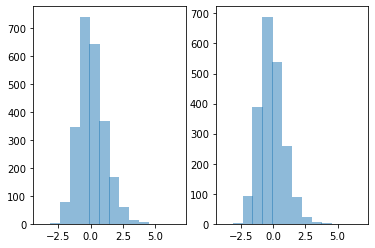

MI = 0.492 ; Feature: MechVentLast8Hour - C1 Mean: 0.324 , C2 Mean: -0.398


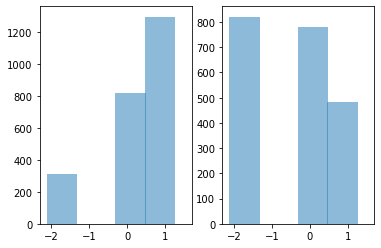

MI = 0.488 ; Feature: CSRU - C1 Mean: -0.333 , C2 Mean: 0.425


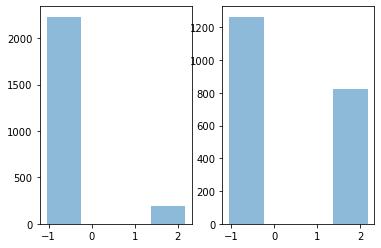

MI = 0.485 ; Feature: PaO2_last - C1 Mean: -0.048 , C2 Mean: -0.031


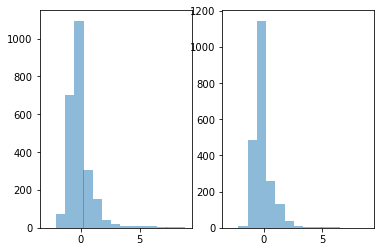

MI = 0.475 ; Feature: HCT_first - C1 Mean: 0.167 , C2 Mean: -0.205


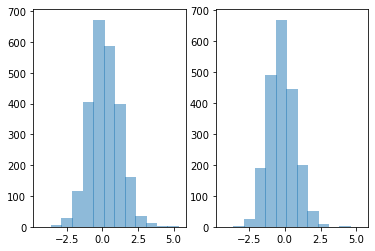

MI = 0.455 ; Feature: NISysABP_first - C1 Mean: 0.139 , C2 Mean: -0.193


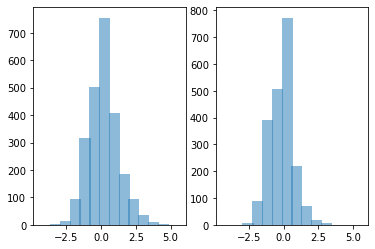

MI = 0.449 ; Feature: NIDiasABP_highest - C1 Mean: 0.164 , C2 Mean: -0.207


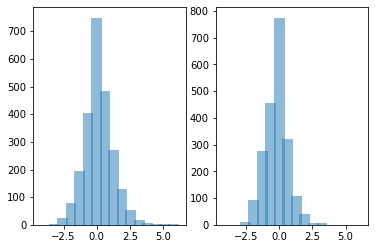

MI = 0.449 ; Feature: Na_first - C1 Mean: -0.067 , C2 Mean: 0.033


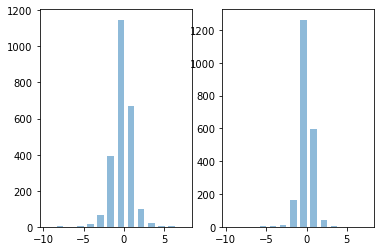



MIFD Analysis of Clusters:  2,0
|C1| =  2238 , |C2| =  2086
MI = 0.77 ; Feature: TroponinI_last - C1 Mean: -0.071 , C2 Mean: -0.054


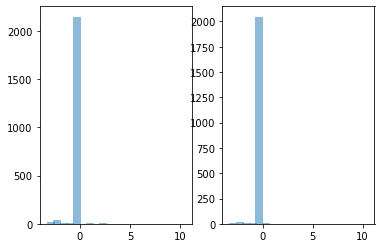

MI = 0.755 ; Feature: TroponinI_first - C1 Mean: -0.06 , C2 Mean: -0.041


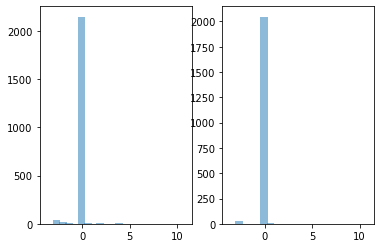

MI = 0.715 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: 0.425


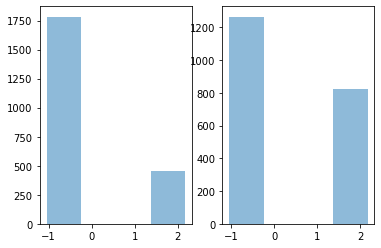

MI = 0.679 ; Feature: SICU - C1 Mean: 0.092 , C2 Mean: 0.012


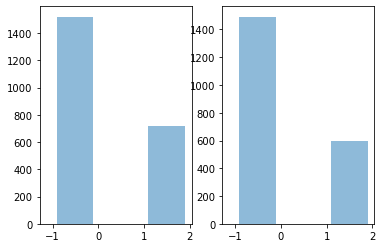

MI = 0.643 ; Feature: CCU - C1 Mean: -0.02 , C2 Mean: -0.194


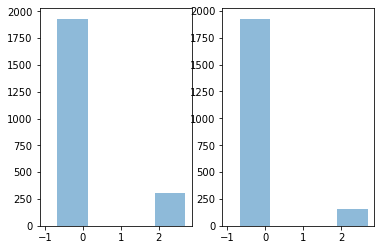

MI = 0.576 ; Feature: K_first - C1 Mean: -0.079 , C2 Mean: -0.091


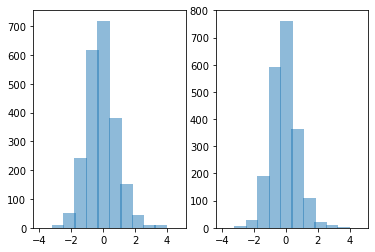

MI = 0.563 ; Feature: HR_first - C1 Mean: -0.016 , C2 Mean: -0.311


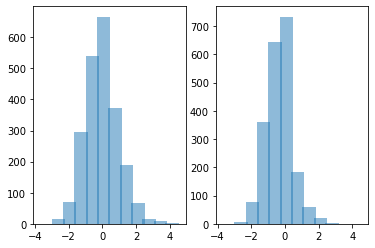

MI = 0.557 ; Feature: Age - C1 Mean: 0.004 , C2 Mean: 0.191


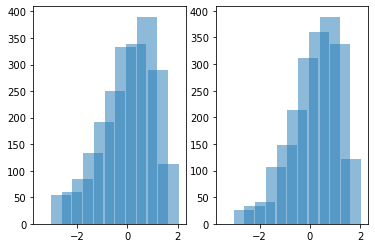

MI = 0.529 ; Feature: SAPS-I - C1 Mean: -0.03 , C2 Mean: -0.147


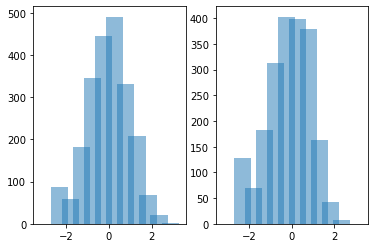

MI = 0.529 ; Feature: NIDiasABP_last - C1 Mean: 0.008 , C2 Mean: -0.07


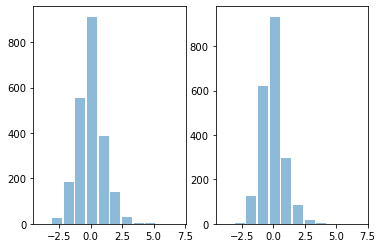



MIFD Analysis of Clusters:  2,1
|C1| =  2238 , |C2| =  2426
MI = 0.917 ; Feature: CCU - C1 Mean: -0.02 , C2 Mean: 0.185


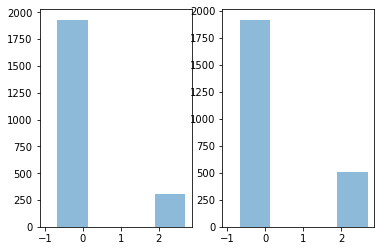

MI = 0.71 ; Feature: SICU - C1 Mean: 0.092 , C2 Mean: -0.095


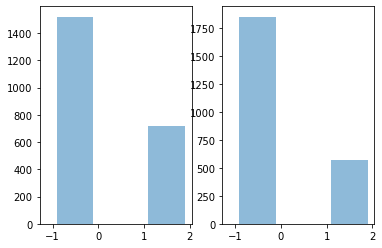

MI = 0.581 ; Feature: TroponinI_first - C1 Mean: -0.06 , C2 Mean: 0.09


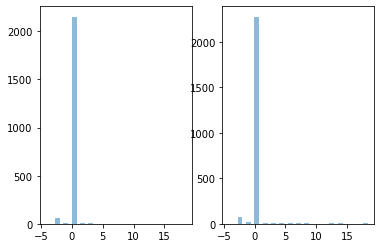

MI = 0.573 ; Feature: NIDiasABP_median - C1 Mean: 0.024 , C2 Mean: 0.17


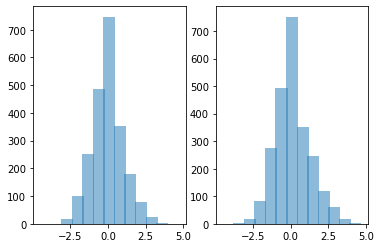

MI = 0.573 ; Feature: NIMAP_median - C1 Mean: 0.028 , C2 Mean: 0.152


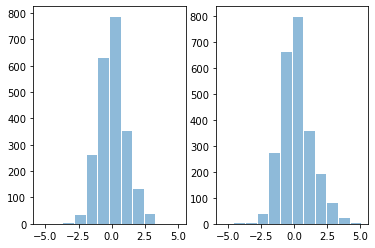

MI = 0.563 ; Feature: NIMAP_first - C1 Mean: 0.028 , C2 Mean: 0.175


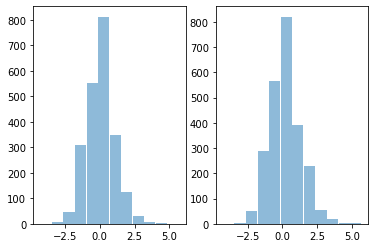

MI = 0.562 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: -0.333


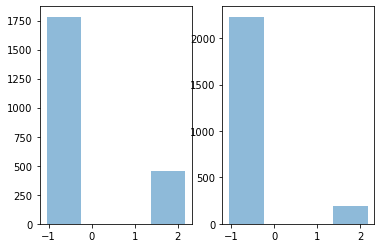

MI = 0.548 ; Feature: SOFA - C1 Mean: -0.061 , C2 Mean: 0.167


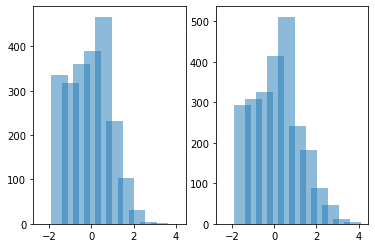

MI = 0.535 ; Feature: DiasABP_last - C1 Mean: -0.023 , C2 Mean: 0.19


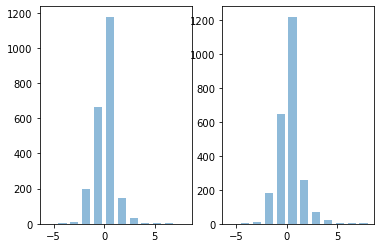

MI = 0.527 ; Feature: NISysABP_highest - C1 Mean: 0.012 , C2 Mean: 0.118


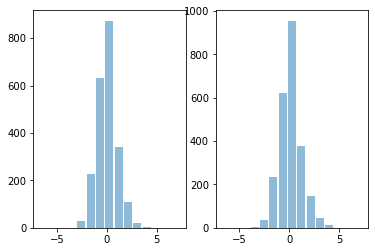

In [132]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = calc_MI(Xi[:,c], Xj[:,c], 0)
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("MIFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C1| = ", len(ci), ", |C2| = ", len(cj))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## HTFD

Hypothesis testing based feature discrimination



1,0
{'SAPS-I': 1.0, 'SOFA': 1.0, 'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0, 'Glucose_first': 1.0}
1.0 SAPS-I - C1: 0.15345951823856196 , C2: -0.14655763751994957


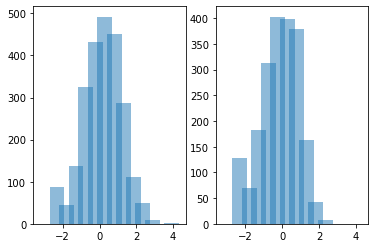

1.0 SOFA - C1: 0.1674780442780594 , C2: -0.12986444922997992


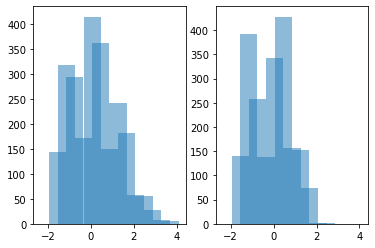

1.0 Length_of_stay - C1: 0.21666239166560722 , C2: -0.23114916940503724


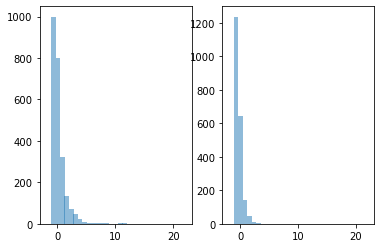

1.0 Age - C1: -0.16809973262997618 , C2: 0.19122668618702704


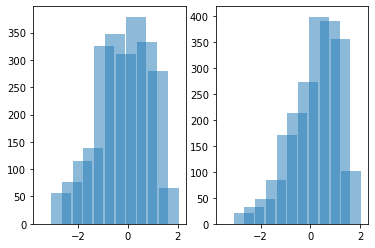

1.0 Weight - C1: 0.20526173426408284 , C2: -0.22095067462244647


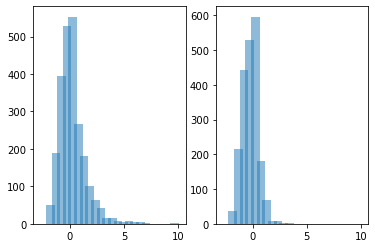

1.0 CCU - C1: 0.1854413519006226 , C2: -0.1944048311536681


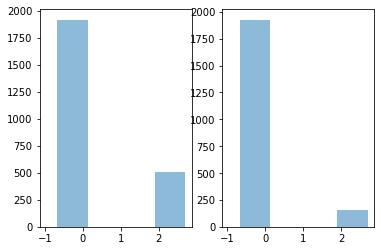

1.0 CSRU - C1: -0.33317452215322463 , C2: 0.4254715179493878


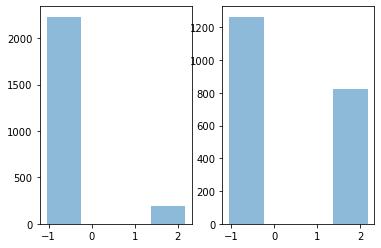

1.0 DiasABP_first - C1: 0.32422241554424125 , C2: -0.30545929687631135


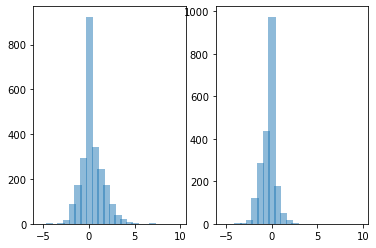

1.0 GCS_first - C1: 0.17701821152004207 , C2: -0.20696105908334356


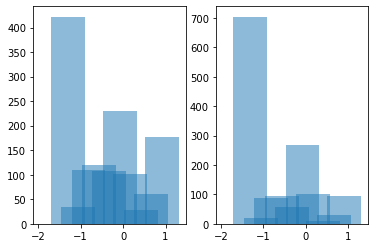

1.0 Glucose_first - C1: 0.3059249429132382 , C2: -0.3062156411010317


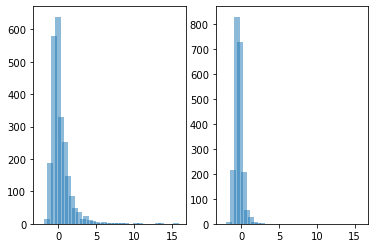



2,0
{'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0, 'Glucose_first': 1.0, 'HR_first': 1.0, 'MAP_first': 1.0}
1.0 Length_of_stay - C1: -0.019412776944528382 , C2: -0.23114916940503724


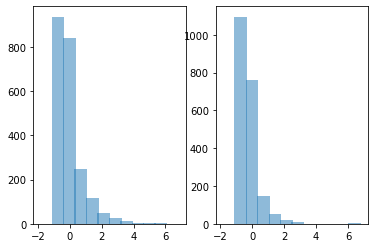

1.0 Age - C1: 0.003981717593468143 , C2: 0.19122668618702704


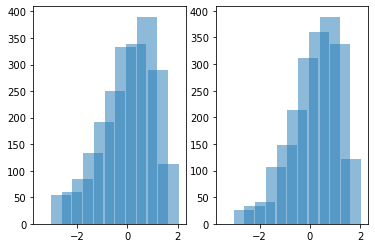

1.0 Weight - C1: -0.016560259187775626 , C2: -0.22095067462244647


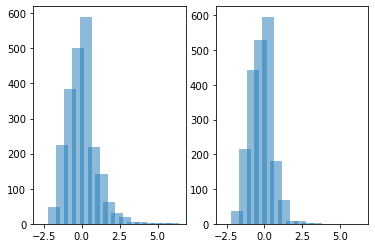

1.0 CCU - C1: -0.01981780246843372 , C2: -0.1944048311536681


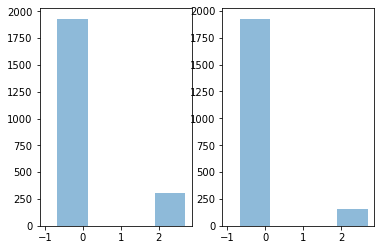

1.0 CSRU - C1: -0.035412062421224466 , C2: 0.4254715179493878


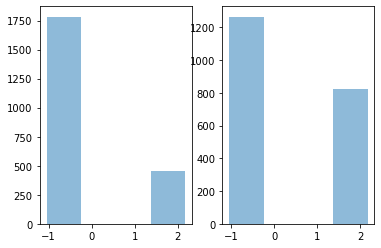

1.0 DiasABP_first - C1: -0.06674507901087752 , C2: -0.30545929687631135


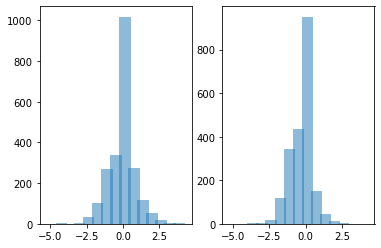

1.0 GCS_first - C1: 0.0010163485702518477 , C2: -0.20696105908334356


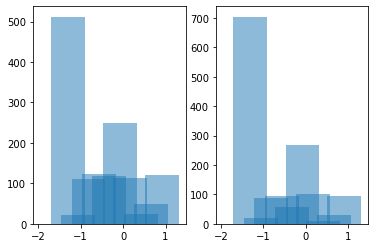

1.0 Glucose_first - C1: -0.04620557827111871 , C2: -0.3062156411010317


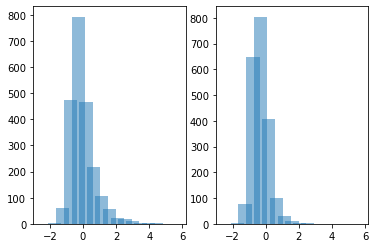

1.0 HR_first - C1: -0.015509233011921022 , C2: -0.31114226114503024


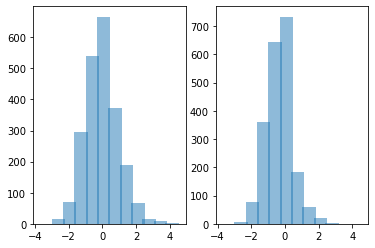

1.0 MAP_first - C1: -0.08318553773522841 , C2: -0.25479285025742826


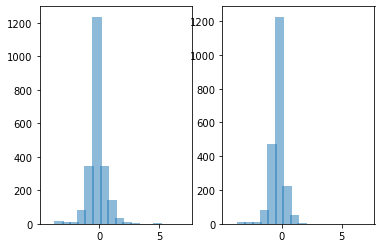



2,1
{'SAPS-I': 1.0, 'SOFA': 1.0, 'Length_of_stay': 1.0, 'Age': 1.0, 'Weight': 1.0, 'CCU': 1.0, 'CSRU': 1.0, 'SICU': 1.0, 'DiasABP_first': 1.0, 'GCS_first': 1.0}
1.0 SAPS-I - C1: -0.029746898740006567 , C2: 0.15345951823856196


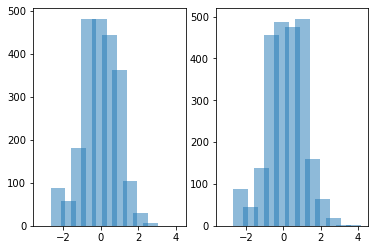

1.0 SOFA - C1: -0.06050245501556481 , C2: 0.1674780442780594


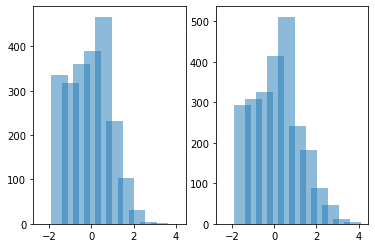

1.0 Length_of_stay - C1: -0.019412776944528382 , C2: 0.21666239166560722


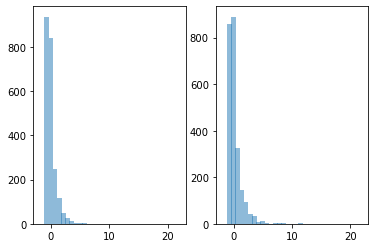

1.0 Age - C1: 0.003981717593468143 , C2: -0.16809973262997618


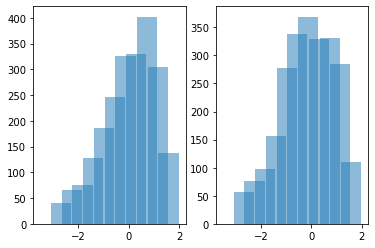

1.0 Weight - C1: -0.016560259187775626 , C2: 0.20526173426408284


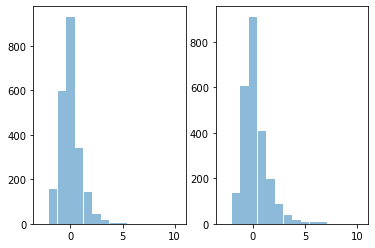

1.0 CCU - C1: -0.01981780246843372 , C2: 0.1854413519006226


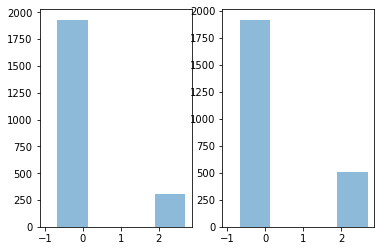

1.0 CSRU - C1: -0.035412062421224466 , C2: -0.33317452215322463


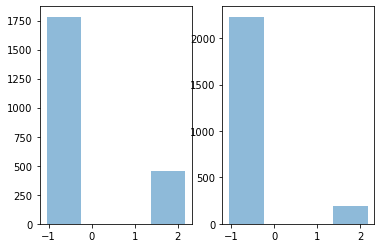

1.0 SICU - C1: 0.0922977777179823 , C2: -0.0953937544911749


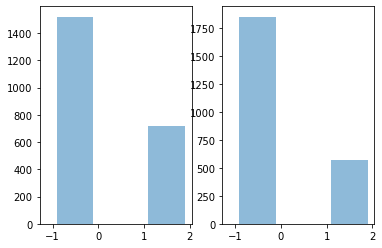

1.0 DiasABP_first - C1: -0.06674507901087752 , C2: 0.32422241554424125


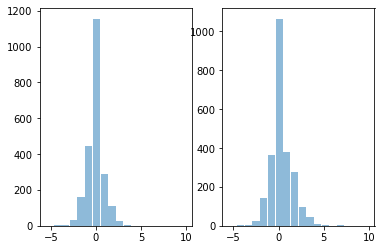

1.0 GCS_first - C1: 0.0010163485702518477 , C2: 0.17701821152004207


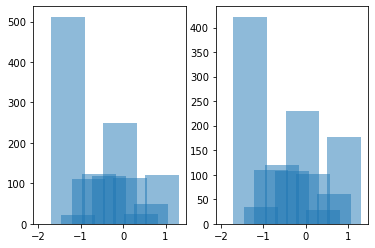

In [134]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
scaled_X_train = X_train
for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi, Xj, axis=0, equal_var=True))[1]
            for c in range(n_columns):
                mi_scores[joint_col_name][c] = np.round(np.exp(-p_vals[c]/0.05), 3)
                # print(column_names[c], ":", c_entropy)
            cntr += 1
            print("\n========\n")
            print(joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            print({column_names[k]: v for k, v in sorted_dict})
            for k, v in sorted_dict:
                print(v, column_names[k], "- C1:", np.mean(scaled_X_train[ci][:,k]), ", C2:", np.mean(scaled_X_train[cj][:,k]))
                plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])

## WDFD

Wasserstein Distance based feature discrimination

In [135]:
cluster_entrpy = 0
cntr = 0
n_columns = X_train.shape[1]
n_clusters = len(torch.unique(cluster_ids))
input_dim = X_train.shape[1]
mi_scores = {}
# scaled_X_train = scale.inverse_transform(X_train)

for i in range(n_clusters):
    for j in range(n_clusters):
        if i > j:
            joint_col_name = str(i) + "," + str(j)
            mi_scores[joint_col_name] = {}
            ci = torch.where(cluster_ids == i)[0]
            cj = torch.where(cluster_ids == j)[0]
            Xi = X_train[ci]
            Xj = X_train[cj]
            col_entrpy = 0
            for c in range(n_columns):
                c_entropy = wd(Xi[:,c], Xj[:,c])
                col_entrpy += c_entropy
                mi_scores[joint_col_name][c] = np.round(c_entropy, 3)
                # print(column_names[c], ":", c_entropy)
            cluster_entrpy += col_entrpy/n_columns
            cntr += 1
            print("\n========\n")
            print("WDFD Analysis of Clusters: ", joint_col_name)
            sorted_dict = sorted(mi_scores[joint_col_name].items(), key=lambda item: -item[1])[:10]
            # print({column_names[k]: v for k, v in sorted_dict})
            print("|C{}| = {}, |C{}| = {}".format(i, len(ci), j, len(cj)))
            print("|C{}| = {:.3f}, |C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci), j, sum(y_train[cj])/len(cj)))
            for k, v in sorted_dict:
                print("MI =", v, "; Feature:", column_names[k], "- C1 Mean:", np.round(np.mean(scaled_X_train[ci][:,k]),3),\
                      ", C2 Mean:", np.round(np.mean(scaled_X_train[cj][:,k]),3))
                # print(scaled_X_train[cj][:,k])
                # plot_hist(scaled_X_train[ci][:,k], scaled_X_train[cj][:,k])



WDFD Analysis of Clusters:  1,0
|C1| = 2426, |C0| = 2086
|C1| = 0.569, |C0| = 0.541
MI = 0.82 ; Feature: GCS_last - C1 Mean: -0.399 , C2 Mean: 0.421
MI = 0.778 ; Feature: BUN_last - C1 Mean: 0.421 , C2 Mean: -0.356
MI = 0.759 ; Feature: CSRU - C1 Mean: -0.333 , C2 Mean: 0.425
MI = 0.733 ; Feature: BUN_first - C1 Mean: 0.385 , C2 Mean: -0.348
MI = 0.726 ; Feature: Creatinine_last - C1 Mean: 0.41 , C2 Mean: -0.316
MI = 0.725 ; Feature: Creatinine_first - C1 Mean: 0.4 , C2 Mean: -0.325
MI = 0.722 ; Feature: MechVentLast8Hour - C1 Mean: 0.324 , C2 Mean: -0.398
MI = 0.719 ; Feature: Glucose_highest - C1 Mean: 0.367 , C2 Mean: -0.352
MI = 0.633 ; Feature: DiasABP_first - C1 Mean: 0.324 , C2 Mean: -0.305
MI = 0.632 ; Feature: HR_median - C1 Mean: 0.294 , C2 Mean: -0.338


WDFD Analysis of Clusters:  2,0
|C2| = 2238, |C0| = 2086
|C2| = 0.564, |C0| = 0.541
MI = 0.461 ; Feature: CSRU - C1 Mean: -0.035 , C2 Mean: 0.425
MI = 0.418 ; Feature: MechVentLast8Hour - C1 Mean: 0.02 , C2 Mean: -0.398
MI

0.46302939626949163


In [136]:
def NHFD_Single_Cluster_Analysis(X_train, cluster_ids, column_names):
    print("\nCluster Wise discriminative features (NHFD)")
    cluster_entrpy = 0
    cntr = 0
    n_columns = X_train.shape[1]
    n_clusters = len(torch.unique(cluster_ids))
    input_dim = X_train.shape[1]
    mi_scores = {}
    for i in range(n_clusters):
        mi_scores[i] = {}
        ci = torch.where(cluster_ids == i)[0]
        for c in range(n_columns):
            Xi_c = X_train[ci][:,c]
            Zc = []
            # Collect values from other clusters
            for j in range(n_clusters):
                if i != j:
                    cj = torch.where(cluster_ids == j)[0]                    
                    Xj_c = X_train[cj][:,c]
                    Zc = np.concatenate([Zc, Xj_c])

            col_entrpy = 0
            p_vals = np.nan_to_num(ttest_ind(Xi_c, Zc, axis=0, equal_var=True))[1]
#             p_vals = np.nan_to_num(wd(Xi_c, Zc))
#             p_vals = np.nan_to_num(calc_MI(Xi_c, Zc,0))
#             mi_scores[i][c] = np.round(np.exp(-p_vals/0.05), 3)
            mi_scores[i][c] = -np.log(p_vals + np.finfo(float).eps)*0.05
#             mi_scores[i][c] = p_vals

        print("\n========\n")
        print("|C{}| = {}".format(i, len(ci)))
        print("|C{}| = {:.3f}".format(i, sum(y_train[ci])/len(ci)))

        sorted_dict = sorted(mi_scores[i].items(), key=lambda item: -item[1])
        for feature, pval in sorted_dict:
            f = column_names[feature]
            print(f, "\t", pval, end='\t')
            for cluster_id in range(n_clusters):
                    c_cluster_id = torch.where(cluster_ids == cluster_id)[0]
                    X_cluster_f = X_train[c_cluster_id][:,feature]
                    print("({:.3f}, {:.3f})".format(np.round(np.mean(X_cluster_f),3), np.round(np.std(X_cluster_f),3)), end='\t')
            print('')


In [138]:
scaled_X_train = scale.inverse_transform(X_train_orig)
NHFD_Single_Cluster_Analysis(scaled_X_train, cluster_ids, column_names)


Cluster Wise discriminative features (NHFD)


|C0| = 2086
|C0| = 0.541
Length_of_stay 	 1.8021826694558578	(-0.245, 0.599)	(0.194, 1.292)	(-0.038, 0.810)	
CCU 	 1.8021826694558578	(-0.218, 0.672)	(0.194, 1.164)	(-0.020, 0.919)	
SICU 	 1.8021826694558578	(0.389, 1.160)	(-0.354, 0.646)	(-0.063, 0.956)	
GCS_first 	 1.8021826694558578	(-0.262, 0.615)	(0.268, 1.000)	(-0.061, 0.745)	
HR_first 	 1.8021826694558578	(-0.313, 0.454)	(0.255, 1.273)	(-0.072, 0.694)	
MAP_first 	 1.8021826694558578	(-0.330, 0.750)	(0.251, 1.097)	(-0.040, 0.946)	
NIDiasABP_first 	 1.8021826694558578	(-0.207, 0.502)	(0.281, 1.197)	(-0.055, 0.677)	
NIMAP_first 	 1.8021826694558578	(-0.226, 0.718)	(0.129, 0.984)	(-0.002, 0.905)	
NISysABP_first 	 1.8021826694558578	(-0.218, 0.723)	(0.154, 1.010)	(0.019, 0.914)	
Glucose_last 	 1.8021826694558578	(0.442, 0.595)	(-0.363, 1.154)	(0.067, 0.900)	
HR_last 	 1.8021826694558578	(-0.239, 0.652)	(0.170, 1.263)	(-0.055, 0.873)	
MAP_last 	 1.8021826694558578	(-0.231, 0.837)	(0.201, 

IndexError: index 116 is out of bounds for axis 0 with size 116

## Local Training

In [23]:
print("\n####################################################################################\n")
print("Training Local Networks")
model = es.load_checkpoint(model)

es = EarlyStoppingCAC(dataset=suffix)

qs, z_train = model(torch.FloatTensor(np.array(X_train)).to(args.device), output="latent")
q_train = qs[0]
cluster_id_train = torch.argmax(q_train, axis=1)

# X_latents_data_loader = list(zip(z_train, cluster_id_train, y_train))
X_latents_data_loader = list(zip(z_train.to(args.device),q_train, y_train))

train_loader_latents = torch.utils.data.DataLoader(X_latents_data_loader,
    batch_size=1024, shuffle=False)

B = []

# plot(model, torch.FloatTensor(np.array(X_train)).to(args.device), y_train,\
#      torch.FloatTensor(np.array(X_test)).to(args.device), y_test)

# Post clustering training
for e in range(N_EPOCHS):
    epoch_loss = 0
    epoch_acc = 0
    epoch_f1 = 0
    acc = 0

    # model.ae.train() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].train()

    # Full training of local networks
    for batch_idx, (X_latents, q_batch, y_batch) in enumerate(train_loader_latents):
        # torch.autograd.set_detect_anomaly(True)

        classifier_labels = np.zeros(len(X_latents))
        # Choose classifier for a point probabilistically
        if args.attention == True:
            for j in range(len(X_latents)):
                classifier_labels[j] = np.random.choice(range(args.n_clusters), p = q_batch[j].detach().numpy())
        else:
            classifier_labels = torch.argmax(q_batch, axis=1).data.cpu().numpy()

        for k in range(args.n_clusters):
            idx_cluster = np.where(classifier_labels == k)[0]
            X_cluster = X_latents[idx_cluster]
            y_cluster = y_batch[idx_cluster]

            classifier_k, optimizer_k = model.classifiers[k]
            # Do not backprop the error to encoder
            y_pred_cluster = classifier_k(X_cluster.detach())
            cluster_loss = torch.mean(criterion(y_pred_cluster, y_cluster))
            optimizer_k.zero_grad()
            cluster_loss.backward(retain_graph=True)
            optimizer_k.step()

    # model.ae.eval() # prep model for evaluation
    for j in range(model.n_clusters):
        model.classifiers[j][0].eval()

    train_preds = torch.zeros((len(z_train), 2))
    train_loss = 0

    # Weighted predictions
    q_train, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
    q_train = q_train[0]
    cluster_ids_train = torch.argmax(q_train, axis=1)

    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_train == j)[0]
        X_cluster = z_train
        y_cluster = torch.Tensor(y_train[cluster_id]).type(torch.LongTensor)

        # Ensemble train loss
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_preds[:,0] += q_train[:,j]*cluster_preds[:,0]
        train_preds[:,1] += q_train[:,j]*cluster_preds[:,1]

        X_cluster = z_train[cluster_id]
        cluster_preds = model.classifiers[j][0](X_cluster)
        train_loss += torch.sum(q_train[cluster_id,j]*criterion(cluster_preds, y_cluster))
        # B.append(torch.max(torch.linalg.norm(X_cluster, axis=1), axis=0).values)


    train_loss /= len(z_train)
    e_train_loss = torch.mean(criterion(train_preds, torch.Tensor(y_train).type(torch.LongTensor)))

    # Evaluate model on Validation set
    qs, z_val = model(torch.FloatTensor(X_val).to(args.device), output="latent")
    q_val = qs[0]
    cluster_ids_val = torch.argmax(q_val, axis=1)
    preds = torch.zeros((len(z_val), 2))

    # Weighted predictions
    for j in range(model.n_clusters):
        cluster_id = np.where(cluster_ids_val == j)[0]
        X_cluster = z_val
        cluster_preds = model.classifiers[j][0](X_cluster)
        preds[:,0] += q_val[:,j]*cluster_preds[:,0]
        preds[:,1] += q_val[:,j]*cluster_preds[:,1]

    val_f1  = f1_score(y_val, np.argmax(preds.detach().numpy(), axis=1))
    val_auc = roc_auc_score(y_val, preds[:,1].detach().numpy())
    val_sil = silhouette_new(z_val.data.cpu().numpy(), cluster_ids_val.data.cpu().numpy(), metric='euclidean')

    val_loss = torch.mean(criterion(preds, torch.Tensor(y_val).type(torch.LongTensor)))
    # record validation loss
    # valid_losses.append(loss.item())

    # calculate average loss over an epoch
    # valid_loss = np.average(valid_losses)
    # avg_valid_losses.append(valid_loss)

    epoch_len = len(str(N_EPOCHS))

    print_msg = (f'\n[{epoch:>{epoch_len}}/{N_EPOCHS:>{epoch_len}}] ' +
                 f'train_loss: {train_loss:.3f} ' +
                 f'valid_loss: {val_loss:.3f} '  +
                 f'valid_F1: {val_f1:.3f} '  +
                 f'valid_AUC: {val_auc:.3f} ' +
                 f'valid_Sil: {val_sil:.3f}')

    print(print_msg)

    # early_stopping needs the validation loss to check if it has decresed, 
    # and if it has, it will make a checkpoint of the current model
    es([val_f1, val_auc], model)
    if es.early_stop == True:
        train_losses.append(train_loss.item())
        e_train_losses.append(e_train_loss.item())
        sil_scores.append(silhouette_new(z_train.data.cpu().numpy(), cluster_ids_train.data.cpu().numpy(), metric='euclidean'))
        nhfd_scores.append(calculate_HTFD(X_train,  cluster_ids_train))
        mifd_scores.append(calculate_MIFD(X_train,  cluster_ids_train))
        # model_complexity.append(calculate_bound(model, B, len(z_train)))
        break



####################################################################################

Training Local Networks
Loading Best model with score:  [0.5863113146933885, 0.7944887455759388]

[ 42/100] train_loss: 0.072 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444
EarlyStopping counter: 1 out of 7

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444
EarlyStopping counter: 2 out of 7

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444
EarlyStopping counter: 3 out of 7

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444
EarlyStopping counter: 4 out of 7

[ 42/100] train_loss: 0.071 valid_loss: 0.219 valid_F1: 0.212 valid_AUC: 0.794 valid_Sil: 0.444
E

## Evaluating on Test Data

In [29]:
X_train, y_train = train_data
print(len(y_train), sum(y_train))
print(X_train[:,4])
col_idx = 4
n_classes = 2
los_quantiles = np.quantile(X_train[:,col_idx], np.arange(n_classes+1)/n_classes)
print(los_quantiles)
y_new = []
for i in range(len(X_train)):
    lbl = int(X_train[i,col_idx]/n_classes)
    for j in range(n_classes):
        if los_quantiles[j] <= X_train[i,col_idx] <= los_quantiles[j+1]:
            lbl = j
    y_new.append(lbl)


6750 954
[-1.12613333 -1.12613333  0.88865161 ... -1.12613333 -1.12613333
  0.88865161]
[-1.12613333  0.88865161  0.88865161]
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8

-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.88865

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.88865

-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.88865161

-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.888

==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.88865

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.88865161

-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.88865161

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.88865

==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.88865

1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.888

0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.88865161

-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 0.8886516129774021 0.8886516129774021
0.8886516129774021 0.8886516129774021 0.8886516129774021
1
==
-1.126133333969493 -1.126133333969493 0.8886516129774021
0.8886516129774021 -1.126133333969493 0.8886516129774021
0
==
-1.126133333969493 -1.126133333969493 0.88865161

In [24]:
print("\n####################################################################################\n")
print("Evaluating Test Data with k = ", args.n_clusters, " Attention = ", args.attention)

# Load best model trained from local training phase
model = es.load_checkpoint(model)

# # Evaluate model on Test dataset
qs, z_test = model(torch.FloatTensor(X_test).to(args.device), output="latent")
q_test = qs[0]
cluster_ids = torch.argmax(q_test, axis=1)
# cluster_ids = np.argmax(distance_matrix(z_test.data.cpu().numpy(), model.cluster_layer.data.cpu().numpy()), axis=1)
test_preds_e = torch.zeros((len(z_test), 2))

test_loss = 0
e_test_loss = 0
local_sum_loss = 0

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds_e[:,0] += q_test[:,j]*cluster_test_preds[:,0]
    test_preds_e[:,1] += q_test[:,j]*cluster_test_preds[:,1]

e_test_loss = torch.mean(criterion(test_preds_e, torch.Tensor(y_test).type(torch.LongTensor)))
e_test_f1 = f1_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_auc = roc_auc_score(y_test, test_preds_e[:,1].detach().numpy())
e_test_acc = accuracy_score(y_test, np.argmax(test_preds_e.detach().numpy(), axis=1))
e_test_nhfd = calculate_HTFD(X_test, cluster_ids)

test_preds = torch.zeros((len(z_test), 2))

# Hard local predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    X_cluster = z_test[cluster_id]
    y_cluster = torch.Tensor(y_test[cluster_id]).type(torch.LongTensor)
    cluster_test_preds = model.classifiers[j][0](X_cluster)
    test_preds[cluster_id,:] = cluster_test_preds
    local_sum_loss += torch.sum(q_test[cluster_id,j]*criterion(cluster_test_preds, y_cluster))

test_f1 = f1_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_auc = roc_auc_score(y_test, test_preds[:,1].detach().numpy())
test_acc = accuracy_score(y_test, np.argmax(test_preds.detach().numpy(), axis=1))
test_loss = torch.mean(criterion(test_preds, torch.Tensor(y_test).type(torch.LongTensor)))
local_sum_loss /= len(X_test)

test_losses.append(test_loss.item())
e_test_losses.append(e_test_loss.item())
local_sum_test_losses.append(local_sum_loss.item())

# enablePrint()
# print("Run #{}".format(r))

print('Loss Metrics - Test Loss {:.3f}, E-Test Loss {:.3f}, Local Sum Test Loss {:.3f}'.format(test_loss, e_test_loss, local_sum_loss))

print('Clustering Metrics     - Acc {:.4f}'.format(acc), ', nmi {:.4f}'.format(nmi),\
      ', ari {:.4f}, NHFD {:.3f}'.format(ari, e_test_nhfd))

print('Classification Metrics - Test F1 {:.3f}, Test AUC {:.3f}, Test ACC {:.3f}'.format(test_f1, test_auc, test_acc),\
    ', E-Test F1 {:.3f}, E-Test AUC {:.3f}, E-Test ACC {:.3f}'.format(e_test_f1, e_test_auc, e_test_acc))

print("\n")
f1_scores.append(e_test_f1)
auc_scores.append(e_test_auc)
# acc_scores.append(e_test_acc)
mifd_scores = []
print("\n")
print("Test F1: ", f1_scores)
print("Test AUC: ", auc_scores)

print("Sil scores: ", sil_scores)
print("NHFD: ", nhfd_scores)
print("MIFD: ", mifd_scores)

print("Train Loss: ", train_losses)
print("E-Train Loss: ", e_train_losses)

print("Test Loss: ", test_losses)
print("E-Test Loss: ", e_test_losses)
print("Local Test Loss: ", local_sum_test_losses)

print("Model Complexity: ", model_complexity)

# enablePrint()
print("Dataset\tk\tF1\tAUC\tACC\tSIL\tNHFD\tMIFD\tW-NHFD")

print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}\t{:.3f}".format\
    (args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores),\
    np.average(acc_scores), np.average(sil_scores), np.average(nhfd_scores),\
    np.average(mifd_scores), np.average(w_nhfd_scores)))

print("\n")


####################################################################################

Evaluating Test Data with k =  3  Attention =  True
Loading Best model with score:  [0.2115869017632242, 0.7944992358256553]

Cluster Wise discriminative features (HTFD)
Loss Metrics - Test Loss 0.223, E-Test Loss 0.222, Local Sum Test Loss 0.074
Clustering Metrics     - Acc 0.0000 , nmi 0.0000 , ari 0.0000, NHFD 0.897
Classification Metrics - Test F1 0.175, Test AUC 0.762, Test ACC 0.926 , E-Test F1 0.178, E-Test AUC 0.778, E-Test ACC 0.926




Test F1:  [0.1782178217821782]
Test AUC:  [0.7775589579663489]
Sil scores:  [0.46088776, 0.46088776]
NHFD:  [1.130516853932585]
MIFD:  []
Train Loss:  [[8.976, 4.562], [5.76, 3.359], [4.233, 2.368], [3.83, 2.096], [3.648, 1.996], [3.621, 1.989], [3.593, 1.978], [3.557, 1.958], [3.53, 1.944], [3.548, 1.95], [3.497, 1.927], [3.483, 1.922], [3.464, 1.92], [3.449, 1.903], [3.41, 1.883], [3.417, 1.893], [3.375, 1.879], [3.319, 1.86], [3.308, 1.866], [3.27, 1.846],

/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/lib/function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/shivin/miniconda/lib/python3.8/site-packages/numpy/core/_methods.py:188: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### K-Means feature segregation ... 

In [35]:
from sklearn.metrics.cluster import adjusted_rand_score as ari_score
km = KMeans(n_clusters=args.n_clusters, n_init=20)
cluster_ids = torch.argmax(q_train, axis=1).data.cpu().numpy()
n_features = X_train.shape[1]
nmi_scores = {}
ari_scores = {}
nmi_sum = 0
ari_sum = 0
for feature in range(n_features):
    feature_labels = km.fit(X_train[:,feature].reshape(-1,1)).labels_
    nmi = nmi_score(feature_labels, cluster_ids)
    ari = ari_score(feature_labels, cluster_ids)
    nmi_sum += nmi
    ari_sum += ari
    nmi_scores[column_names[feature]] = np.round(nmi, 3)
    ari_scores[column_names[feature]] = np.round(ari, 3)

nmi_sum, ari_sum
{k: v for k, v in sorted(nmi_scores.items(), key=lambda item: item[1])}
{k: v for k, v in sorted(ari_scores.items(), key=lambda item: item[1])}

NameError: name 'KMeans' is not defined

## Knowledge Distilation based Feature Importance

Training data


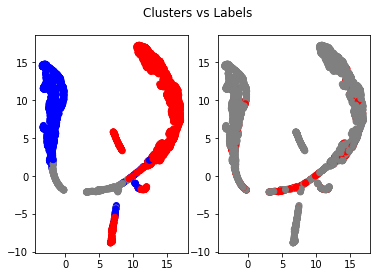

Cluster #  0 sized:  1351 +/- 0.33974833456698744
[('GCS Verbal', 0.301), ('Extubated', 0.066), ('GCS Eye', 0.049), ('Ventilator', 0.042), ('Minute Volume', 0.04), ('PaO2', 0.039), ('Gender_1', 0.039), ('Mean Airway Pressure', 0.038), ('Ethnicity_2', 0.036), ('Respiratory rate', 0.035)]

Cluster #  1 sized:  6736 +/- 0.04913895486935867
[('Heart Rate', 0.093), ('Extubated', 0.077), ('GCS Verbal', 0.077), ('Respiratory rate', 0.071), ('Ethnicity_2', 0.068), ('Age', 0.063), ('Mean Airway Pressure', 0.062), ('Blood urea nitrogen', 0.059), ('Gender_1', 0.052), ('PIP', 0.045)]

Cluster #  2 sized:  4555 +/- 0.04193194291986828
[('Gender_2', 0.284), ('Respiratory rate', 0.088), ('pH Urine', 0.072), ('Heart Rate', 0.071), ('Blood urea nitrogen', 0.048), ('Gender_1', 0.047), ('Albumin', 0.044), ('Age', 0.043), ('PaO2', 0.043), ('Blood culture', 0.043)]



In [25]:
####################################################################################
####################################################################################
####################################################################################
################################### Feature Imp. ###################################
####################################################################################
####################################################################################
####################################################################################

plot(model, torch.FloatTensor(X_train).to(args.device), y_train, labels=None)

regs = [GradientBoostingRegressor(random_state=0) for _ in range(args.n_clusters)]
qs, z_train = model(torch.FloatTensor(X_train).to(args.device), output="latent")
q_train = qs[0]
cluster_ids = torch.argmax(q_train, axis=1)
preds_e = torch.zeros((len(z_train), 2))
feature_importances = np.zeros((args.n_clusters, args.input_dim))

# Weighted predictions
for j in range(model.n_clusters):
    cluster_id = np.where(cluster_ids == j)[0]
    # X_cluster = z_test[cluster_id]
    X_cluster = z_train
    cluster_preds = model.classifiers[j][0](X_cluster)
    # print(q_test, cluster_preds[:,0])
    preds_e[:,0] += q_train[:,j]*cluster_preds[:,0]
    preds_e[:,1] += q_train[:,j]*cluster_preds[:,1]

for j in range(model.n_clusters):
    cluster_id = torch.where(cluster_ids == j)[0]
    X_cluster = X_train[cluster_id]
    if args.attention == True:
        y_cluster = preds_e[cluster_id][:,1]
    else:
        y_cluster = preds[cluster_id][:,1]

    # Some test data might not belong to any cluster
    if len(cluster_id) > 0:
        regs[j].fit(X_cluster, y_cluster.detach().cpu().numpy())
        best_features = np.argsort(regs[j].feature_importances_)[::-1][:10]
        feature_importances[j,:] = regs[j].feature_importances_
        print("Cluster # ", j, "sized: ", len(cluster_id), "+/-", sum(y_train[cluster_id])/len(cluster_id))
        print(list(zip(column_names[best_features], np.round(regs[j].feature_importances_[best_features], 3))))
        print("=========================\n")


## Baseline Model

In [1]:
f1_scores, auc_scores, acc_scores = [], [], []
if args.verbose == "False":
    blockPrint()

for r in range(args.n_runs):
    model = NNClassifier(args, input_dim=args.input_dim)
    device = args.device

    N_EPOCHS = args.n_epochs
    es = EarlyStopping(dataset=args.dataset)

    for e in range(1, N_EPOCHS):
        epoch_loss = 0
        epoch_auc = 0
        epoch_f1 = 0
        auc = 0
        model.train()
        for X_batch, y_batch, _ in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_pred, train_loss = model.fit(X_batch, y_batch)
            epoch_loss += train_loss

            f1 = f1_score(np.argmax(y_pred, axis=1), y_batch.detach().numpy(), average="macro")
            auc = multi_class_auc(y_batch, y_pred, args.n_classes)
            epoch_auc += auc.item()
            epoch_f1 += f1.item()

        model.classifier.eval()
        val_pred, _ = model(torch.FloatTensor(np.array(X_val)).to(args.device))
        val_loss = nn.CrossEntropyLoss(reduction='mean')(val_pred, torch.tensor(y_val).to(device))

        val_f1 = f1_score(np.argmax(val_pred.detach().numpy(), axis=1), y_val, average="macro")
        val_auc = multi_class_auc(y_val, val_pred.detach().numpy(), args.n_classes)
        es([val_f1, val_auc], model)

        print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
        	f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Auc: {epoch_auc/len(train_loader):.3f} | ',
        	f'Val F1: {val_f1:.3f} | Val Auc: {val_auc:.3f} | Val Loss: {val_loss:.3f}')

        if es.early_stop == True:
            break


    ####################################################################################
    ####################################################################################
    ####################################################################################
    ###################################### Testing #####################################
    ####################################################################################
    ####################################################################################
    ####################################################################################

    print("\n####################################################################################\n")
    print("Evaluating Test Data")

    # Load best model trained from local training phase
    model = es.load_checkpoint(model)
    model.classifier.eval()
    test_pred, _ = model(torch.FloatTensor(np.array(X_test)).to(args.device))
    test_loss = nn.CrossEntropyLoss(reduction='mean')(test_pred, torch.tensor(y_test).to(device))

    test_f1 = f1_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test, average="macro")
    test_auc = multi_class_auc(y_test, test_pred.detach().numpy(), args.n_classes)
    test_acc = accuracy_score(np.argmax(test_pred.detach().numpy(), axis=1), y_test)

    y_preds = np.argmax(test_pred.detach().numpy(), axis=1)
    # print(confusion_matrix(y_test, y_preds))

    print(f'Epoch {e+0:03}: | Train Loss: {epoch_loss/len(train_loader):.5f} | ',
    	f'Train F1: {epoch_f1/len(train_loader):.3f} | Train Auc: {epoch_auc/len(train_loader):.3f}| ',
    	f'Test F1: {test_f1:.3f} | Test Auc: {test_auc:.3f} | Test Loss: {test_loss:.3f}')

    print("\n####################################################################################\n")
    f1_scores.append(test_f1)
    auc_scores.append(test_auc)
    acc_scores.append(test_acc)

    # reg = GradientBoostingRegressor(random_state=0)

    # reg.fit(X_test, y_test)
    # best_features = np.argsort(reg.feature_importances_)[::-1][:10]
    # print("Best Features ")
    # print(column_names[best_features])
    # print("=========================\n")

enablePrint()
print("F1:", f1_scores)
print("AUC:", auc_scores)
print("ACC:", acc_scores)
print("Dataset\tk\tF1\tAUC\tACC")
print("{}\t{}\t{:.3f}\t{:.3f}\t{:.3f}".format(args.dataset, args.n_clusters, np.average(f1_scores), np.average(auc_scores), np.average(acc_scores)))

NameError: name 'args' is not defined